# Audio classification using CNN

BG:
科学家对地球上日益减少的雨林感到担忧。世界每年损失多达1000万英亩的原始雨林，其中大部分是由于非法砍伐造成的。森林砍伐以及其他原因导致的破坏约占全球碳排放量的10%。
科学家团队计划将数千部报废的智能手机改造成太阳能供电的监听设备，并将它们部署在整个亚马逊雨林中，用于根据电锯声和卡车发动机声发出警报。
现在需要一款能够安装在这些手机上的软件，该软件可以使用人工智能 (AI) 实时识别这些声音。

音频分类可以通过将音频流转换为声谱图，声谱图提供了频谱随时间变化的可视化表示。
再使用卷积神经网络 (CNN) 对声谱图进行详细分类。
下图中的声谱图是从带有电锯声的WAV文件生成的，背景中还有雨林的声音。

本Notebook中使用 Keras 构建一个 CNN 网络，实现识别伐木作业的标志性声音，并将其与野生动物和雷暴等环境声音区分开来的目标。

## Generate spectrograms

 “Sounds” 目录包含名为 "background"（背景）、"chainsaw"（电锯）、"engine"（引擎）和 "storm"（风暴）的子目录。
 每个子目录包含100个WAV文件。
 “background”目录中的WAV文件仅包含雨林的背景噪声，而其他子目录中的文件则在背景噪声的基础上叠加了电锯、引擎和雷暴的声音。
 WAV文件是通过使用名为 Scaper 的音景合成软件包生成的，将 UrbanSound8K 数据集中公开的声音与从YouTube获取的雨林声音结合在一起得到当前的数据集。

第一步是加载WAV文件，使用一个名为 Librosa 的Python包从中生成声谱图图像，将声谱图加载到内存中，并为训练CNN做好准备。
为此，首先将定义一对辅助函数，用于将WAV文件转换为声谱图，并将指定目录中的所有WAV文件批量转换为声谱图。

In [1]:
import numpy as np  # 导入数值计算库numpy，主要用于数组和矩阵操作
import librosa.display, os  # 导入librosa.display用于音频可视化，os模块用于文件和目录操作
import matplotlib.pyplot as plt  # 导入matplotlib.pyplot，用于绘图
%matplotlib inline  # 在Jupyter Notebook中启用内嵌图显示（若在脚本中运行可以去掉）

def create_spectrogram(audio_file, image_file):
    # 创建音频文件的频谱图并保存为图片
    fig = plt.figure()  # 创建一个新的图像对象
    ax = fig.add_subplot(1, 1, 1)  # 在图中添加一个子图（1行1列中的第1个）
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)  # 调整子图的边距，使其充满整个图像区域

    y, sr = librosa.load(audio_file)  # 使用librosa加载音频文件，y是音频时间序列，sr是采样率
    ms = librosa.feature.melspectrogram(y, sr=sr)  # 计算音频的Mel频谱图
    log_ms = librosa.power_to_db(ms, ref=np.max)  # 将Mel频谱图转换为对数刻度，以dB（分贝）表示
    librosa.display.specshow(log_ms, sr=sr)  # 使用librosa.display绘制频谱图

    fig.savefig(image_file)  # 将生成的频谱图保存为图片文件
    plt.close(fig)  # 关闭图像，释放内存
    
def create_pngs_from_wavs(input_path, output_path):
    # 从指定输入路径的.wav文件创建对应的频谱图，并保存到输出路径
    if not os.path.exists(output_path):  # 如果输出路径不存在
        os.makedirs(output_path)  # 创建输出路径

    dir = os.listdir(input_path)  # 获取输入路径中的文件列表

    for i, file in enumerate(dir):  # 遍历文件列表
        input_file = os.path.join(input_path, file)  # 生成输入文件的完整路径
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))  # 将.wav扩展名替换为.png，并生成输出文件路径
        create_spectrogram(input_file, output_file)  # 调用create_spectrogram函数创建频谱图并保存

从 "Sounds/background" 目录中的所有WAV文件创建包含声谱图的PNG文件。

In [2]:
create_pngs_from_wavs('Sounds/background', 'Spectrograms/background')

从 "Sounds/chainsaw" 目录中的所有WAV文件创建包含声谱图的PNG文件。

In [3]:
create_pngs_from_wavs('Sounds/chainsaw', 'Spectrograms/chainsaw')

从 "Sounds/engine" 目录中的所有WAV文件创建包含声谱图的PNG文件。

In [4]:
create_pngs_from_wavs('Sounds/engine', 'Spectrograms/engine')

从 "Sounds/storm" 目录中的所有WAV文件创建包含声谱图的PNG文件。

In [5]:
create_pngs_from_wavs('Sounds/storm', 'Spectrograms/storm')

定义两个新的辅助函数用于加载和显示声谱图，并声明两个Python列表——一个用于存储声谱图图像，另一个用于存储类别标签。

In [6]:
from keras.preprocessing import image  # 导入Keras中用于图像处理的模块
import os  # 导入os模块，用于处理文件路径和目录
import matplotlib.pyplot as plt  # 导入matplotlib库以用于可视化

# 定义一个函数，用于从给定路径加载图像，并为它们设置标签
def load_images_from_path(path, label):
    images = []  # 初始化一个列表，用于存储加载的图像
    labels = []  # 初始化一个列表，用于存储对应的图像标签

    # 遍历给定路径中的所有文件
    for file in os.listdir(path):
        # 加载图像并将其转换为数组，同时调整图像大小为224x224，通道数为3（RGB）
        img = image.load_img(os.path.join(path, file), target_size=(224, 224, 3))
        img_array = image.img_to_array(img)  # 将图像转换为数组格式
        images.append(img_array)  # 将图像数组添加到images列表中
        labels.append(label)  # 将对应的标签添加到labels列表中
    
    return images, labels  # 返回加载的图像和对应的标签

# 定义一个函数，用于显示给定的图像
def show_images(images):
    # 创建一个包含8个子图的图形，用于展示图像
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    # 遍历axes中的子图，并将对应的图像显示在每个子图中
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)  # 显示图像，将像素值缩放到0到1之间

# 初始化两个空列表，用于存储所有的图像和标签
x = []  # 图像数据列表
y = []  # 标签列表

加载背景声谱图图像，将它们添加到名为 x 的列表中，并用 0 进行标记。

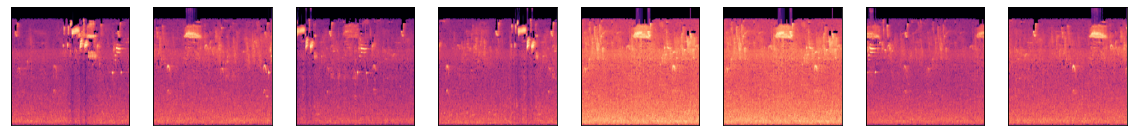

In [7]:
# 从路径 'Spectrograms/background' 加载图像和标签，类别标签为 0
# load_images_from_path 函数用于从指定路径加载图像文件并返回图像及其对应的标签
images, labels = load_images_from_path('Spectrograms/background', 0)

# 显示加载的图像
# show_images 函数用于显示已加载的图像，便于可视化检查
show_images(images)

# 将加载的图像和标签分别添加到 x 和 y 中
# x 和 y 可以理解为存储训练数据的列表或数组，其中 x 存储图像，y 存储对应的标签
x += images
y += labels


加载电锯声谱图图像，将它们添加到名为 x 的列表中，并用 1 进行标记。

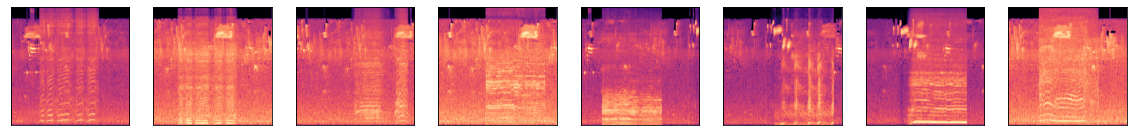

In [8]:
# 从指定路径加载图像和标签
# load_images_from_path 函数从给定路径 'Spectrograms/chainsaw' 中加载图像
# 参数 '1' 可能用于指定某种模式，比如类别标签
images, labels = load_images_from_path('Spectrograms/chainsaw', 1)

# 显示加载的图像
# 调用 show_images 函数来显示之前加载的图像数据
show_images(images)

# 将加载的图像数据添加到已有数据集合中
# 假设 x 和 y 是在此之前定义的列表或者数组，用于存储图像数据和标签
# x += images 将加载的新图像追加到已有的 x 集合中\# y += labels 将加载的新标签追加到已有的 y 集合中
x += images
y += labels

加载引擎声谱图图像，将它们添加到名为 x 的列表中，并用 2 进行标记。

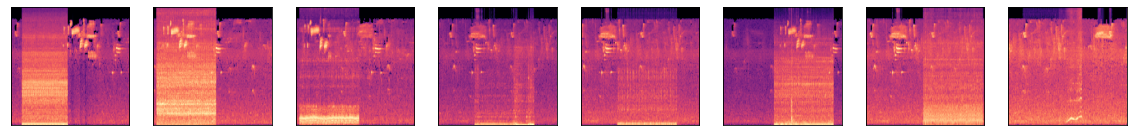

In [9]:
# 从指定路径中加载图像和标签
images, labels = load_images_from_path('Spectrograms/engine', 2)
# 调用函数显示加载的图像
show_images(images)

# 将加载的图像添加到变量 x 中
x += images
# 将加载的标签添加到变量 y 中
y += labels

加载风暴声谱图图像，将它们添加到名为 x 的列表中，并用 3 进行标记。

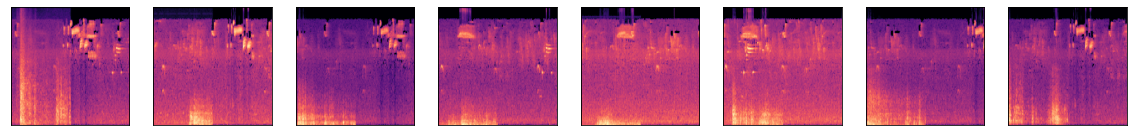

In [10]:
# 从指定路径加载图像并显示

# 加载图像和标签，从路径 'Spectrograms/storm' 读取，'3' 表示加载第 3 类（可能是文件夹中的子类别）
images, labels = load_images_from_path('Spectrograms/storm', 3)

# 显示加载的图像，用于检查图像是否正确加载
show_images(images)

# 假设变量 'x' 和 'y' 是用于存储训练数据和标签的列表或数组
# 将加载的图像追加到变量 'x' 中
x += images

# 将加载的标签追加到变量 'y' 中
y += labels

将图像和标签分为两个数据集——一个用于训练，另一个用于测试。然后将像素值除以255，并使用Keras的 to_categorical 函数对标签进行 one-hot 编码。

In [11]:
from tensorflow.keras.utils import to_categorical  # 从TensorFlow的Keras模块导入to_categorical函数，用于将标签转换为独热编码（one-hot encoding）
from sklearn.model_selection import train_test_split  # 从scikit-learn库中导入train_test_split函数，用于将数据集划分为训练集和测试集

# 使用train_test_split函数将特征数据x和标签数据y划分为训练集和测试集
# 参数说明：
# x：特征数据集
# y：标签数据集
# stratify=y：按y的比例来分配数据，以保证训练集和测试集中标签的比例一致
# test_size=0.3：测试集的大小为总数据集的30%
# random_state=0：设置随机种子，保证每次分割结果一致
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

# 对训练集和测试集的特征数据进行归一化处理，将像素值范围缩放到[0, 1]
# 使用numpy数组将数据除以255，使得像素值从0-255范围缩放到0-1之间
x_train_norm = np.array(x_train) / 255  # 归一化训练集特征数据
x_test_norm = np.array(x_test) / 255  # 归一化测试集特征数据

# 将训练集和测试集的标签数据转换为独热编码形式
# 例如：如果标签是2，则转换为[0, 0, 1, 0, ...]
y_train_encoded = to_categorical(y_train)  # 对训练集标签进行独热编码
y_test_encoded = to_categorical(y_test)  # 对测试集标签进行独热编码

## Build and train a CNN

最先进的图像分类通常不是通过传统神经网络完成的，而是通过卷积神经网络（CNN）来实现的。
CNN 使用卷积层从图像中提取特征，并通过池化层对图像进行下采样，从而可以在不同分辨率下检测特征。
接下来的任务是构建一个包含一系列用于特征提取的卷积层和池化层、两个用于分类的全连接层以及输出各类别概率的 softmax 层的 CNN，并使用声谱图图像和标签对其进行训练。

首先定义 CNN。

In [12]:
# 导入必要的模块
from keras.models import Sequential  # 导入顺序模型类，用于构建神经网络的框架
from keras.layers import Conv2D, MaxPooling2D  # 导入卷积层和最大池化层
from keras.layers import Flatten, Dense  # 导入扁平化层和全连接层

# 创建一个顺序模型，用于构建神经网络的框架
model = Sequential()

# 添加一个卷积层
# 参数解释：
# 1. filters=32：卷积核的数量为32，代表输出特征图的通道数
# 2. kernel_size=(3, 3)：卷积核的大小为3x3
# 3. activation='relu'：使用ReLU激活函数，可以引入非线性特性
# 4. input_shape=(224, 224, 3)：输入数据的形状为224x224的大小，3个颜色通道（RGB）
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

# 添加一个最大池化层
# 参数解释：
# 1. pool_size=(2, 2)：最大池化窗口大小为2x2
model.add(MaxPooling2D(2, 2))

# 添加第二个卷积层，输出特征图的数量增至128
model.add(Conv2D(128, (3, 3), activation='relu'))

# 添加第二个最大池化层
model.add(MaxPooling2D(2, 2))

# 添加第三个卷积层
model.add(Conv2D(128, (3, 3), activation='relu'))

# 添加第三个最大池化层
model.add(MaxPooling2D(2, 2))

# 添加第四个卷积层
model.add(Conv2D(128, (3, 3), activation='relu'))

# 添加第四个最大池化层
model.add(MaxPooling2D(2, 2))

# 添加一个扁平化层，将三维的特征图变成一维向量，方便传入全连接层
model.add(Flatten())

# 添加一个全连接层，输出单元为1024，使用ReLU激活函数
model.add(Dense(1024, activation='relu'))

# 添加输出层
# 参数解释：
# 1. units=4：输出单元数量为4，表示有4个分类
# 2. activation='softmax'：使用Softmax激活函数，将输出转化为概率分布
model.add(Dense(4, activation='softmax'))

# 编译模型
# 参数解释：
# 1. optimizer='adam'：使用Adam优化器进行梯度下降
# 2. loss='categorical_crossentropy'：损失函数为交叉熵，适用于多分类任务
# 3. metrics=['accuracy']：模型的评价指标为准确率
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型的摘要信息
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

训练 CNN，并将 fit 返回的 history 对象保存在一个本地变量中。

In [13]:
# 使用模型进行训练，并将训练过程的历史记录存储在变量 hist 中
hist = model.fit(
    x_train_norm,  # 训练集输入数据，已经进行归一化处理（例如，将数据缩放到0到1之间）
    y_train_encoded,  # 训练集标签，通常为独热编码（one-hot encoded）形式，用于表示分类标签
    validation_data=(x_test_norm, y_test_encoded),  # 验证数据，用于在每个epoch结束后评估模型性能，包含验证集输入数据（也进行了归一化处理）和验证集标签
    batch_size=10,  # 批次大小，每次训练中使用的样本数量为10。通过分批次训练可以使模型更快收敛，尤其在处理大数据集时很有效
    epochs=10  # 训练的轮次，总共对整个训练集迭代10次。每次迭代模型都会对整个训练集进行一次学习
)

Epoch 1/10
28/28 [==============================] - 16s 286ms/step - loss: 1.6980 - accuracy: 0.2505 - val_loss: 1.3274 - val_accuracy: 0.2583
Epoch 2/10
28/28 [==============================] - 8s 270ms/step - loss: 1.1328 - accuracy: 0.4759 - val_loss: 0.9119 - val_accuracy: 0.5833
Epoch 3/10
28/28 [==============================] - 8s 271ms/step - loss: 0.8465 - accuracy: 0.5694 - val_loss: 0.6740 - val_accuracy: 0.6750
Epoch 4/10
28/28 [==============================] - 8s 276ms/step - loss: 0.6634 - accuracy: 0.6756 - val_loss: 0.7148 - val_accuracy: 0.6500
Epoch 5/10
28/28 [==============================] - 8s 275ms/step - loss: 0.5162 - accuracy: 0.7561 - val_loss: 0.6361 - val_accuracy: 0.6917
Epoch 6/10
28/28 [==============================] - 8s 275ms/step - loss: 0.5723 - accuracy: 0.6714 - val_loss: 0.6267 - val_accuracy: 0.6667
Epoch 7/10
28/28 [==============================] - 8s 277ms/step - loss: 0.5225 - accuracy: 0.7523 - val_loss: 0.9200 - val_accuracy: 0.5583
Epoch

绘制训练和验证的准确率。

[]

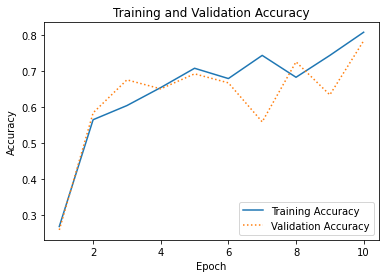

In [14]:
# 从训练历史记录中获取训练集的准确率和验证集的准确率
acc = hist.history['accuracy']  # 训练集的准确率
val_acc = hist.history['val_accuracy']  # 验证集的准确率

# 定义训练轮次的范围，起始值为 1，结束值为训练轮次的数量加 1
# 因为训练轮次是从 1 开始计数的，而不是从 0 开始
epochs = range(1, len(acc) + 1)

# 使用 Matplotlib 库绘制训练准确率的折线图
# '-' 表示折线的样式为实线
plt.plot(epochs, acc, '-', label='Training Accuracy')

# 使用 Matplotlib 库绘制验证准确率的折线图
# ':' 表示折线的样式为虚线
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')

# 为图表添加标题
plt.title('Training and Validation Accuracy')

# 为图表添加 X 轴标签，表示训练的轮次
plt.xlabel('Epoch')

# 为图表添加 Y 轴标签，表示准确率
plt.ylabel('Accuracy')

# 为图表添加图例，图例的位置设置为右下角
plt.legend(loc='lower right')

# 绘制图表
plt.plot()

 鉴于网络仅使用280张图像进行训练，准确率已经相当不错了，但通过采用迁移学习可能能够实现更高的准确率。

## Use transfer learning to improve accuracy

迁移学习 是一种强大的技术，允许Google、Microsoft等公司使用GPU训练的复杂CNN被重新利用，用于解决特定领域的问题。许多预训练的CNN在公共领域中可用，Keras中也包含了几个。

这里使用 MobileNetV2，Google推出的经过预训练且为移动设备优化的CNN，用于从声谱图图像中提取特征。

MobileNetV2 所需的处理能力较少，内存占用也比 ResNet50V2 等CNN更小。这就是为什么它非常适合移动设备。

首先调用Keras的 MobileNetV2 函数，在不包含分类层的情况下实例化 MobileNetV2。

使用适用于 MobileNet 网络的 preprocess_input 函数来预处理训练和测试图像。然后通过 MobileNetV2 运行两个数据集以提取特征。

In [15]:
from tensorflow.keras.applications import MobileNetV2  # 从 Keras 应用模块中导入 MobileNetV2 模型
from tensorflow.keras.applications.mobilenet import preprocess_input  # 导入 MobileNet 相关的预处理函数
import numpy as np  # 导入 numpy 库以便操作数组

# 创建一个 MobileNetV2 的基础模型，该模型使用 ImageNet 的预训练权重
# 参数解释：
# - weights='imagenet' 表示使用在 ImageNet 数据集上训练的预训练权重
# - include_top=False 表示不包含模型最后的全连接层（适用于特征提取）
# - input_shape=(224, 224, 3) 指定输入图像的大小为 224x224，具有 3 个颜色通道（RGB）
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 将训练集图像数据进行预处理
# preprocess_input 函数用于对输入的数据进行归一化和标准化处理，
# 使得数据符合 MobileNetV2 模型所要求的输入格式。
x_train_norm = preprocess_input(np.array(x_train))

# 同样对测试集图像数据进行预处理
x_test_norm = preprocess_input(np.array(x_test))

# 使用 MobileNetV2 的基础模型对预处理后的训练集图像提取特征
# base_model.predict 函数用于对输入数据进行前向传播计算，输出高层特征表示
train_features = base_model.predict(x_train_norm)

# 对测试集图像进行特征提取
# 提取的特征可以用于后续的分类器训练或者迁移学习
test_features = base_model.predict(x_test_norm)

定义一个神经网络来对 MobileNetV2 提取的特征进行分类。

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# 创建一个顺序模型
model = Sequential()

# 将输入数据展平为一维向量（将多维输入转化为一维）
# 这里的输入数据形状为 train_features 的所有维度（除了第一维）
model.add(Flatten(input_shape=train_features.shape[1:]))

# 添加一个全连接层，包含 1024 个神经元，激活函数为 ReLU
# ReLU 激活函数可以增加模型的非线性能力，从而提高模型的表达能力
model.add(Dense(1024, activation='relu'))

# 添加输出层，包含 4 个神经元，激活函数为 softmax
# 这里有 4 个输出神经元，意味着模型的输出是 4 个类别之一
# softmax 用于多分类问题，可以将输出转换为概率分布
model.add(Dense(4, activation='softmax'))

# 编译模型，指定优化器、损失函数和评估指标
# 优化器为 Adam，适用于大多数神经网络优化问题
# 损失函数为 categorical_crossentropy，适用于多分类问题
# 评估指标为准确率（accuracy）
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

使用 MobileNetV2 提取的特征来训练该网络

In [17]:
# 使用模型训练数据并进行拟合
# model.fit() 是用于训练模型的函数
# train_features: 训练集的特征数据（自变量）
# y_train_encoded: 训练集的目标标签（因变量），经过编码以适应模型输入格式
# validation_data: 验证集的数据，用于在训练过程中评估模型性能，以防止过拟合
#   (test_features, y_test_encoded): 验证数据，包含特征和对应的目标标签
# batch_size: 批次大小，每次更新权重时使用的样本数量，这里设置为 10
# epochs: 训练周期数，模型将在整个训练集上迭代多少次，这里设置为 10
hist = model.fit(train_features, y_train_encoded,
                 validation_data=(test_features, y_test_encoded),
                 batch_size=10,
                 epochs=10)


Epoch 1/10
28/28 [==============================] - 4s 131ms/step - loss: 31.6268 - accuracy: 0.5466 - val_loss: 3.7857 - val_accuracy: 0.8583
Epoch 2/10
28/28 [==============================] - 4s 125ms/step - loss: 1.6843 - accuracy: 0.9399 - val_loss: 2.0175 - val_accuracy: 0.9250
Epoch 3/10
28/28 [==============================] - 4s 125ms/step - loss: 0.3810 - accuracy: 0.9782 - val_loss: 8.0027 - val_accuracy: 0.8417
Epoch 4/10
28/28 [==============================] - 4s 126ms/step - loss: 1.9832 - accuracy: 0.9639 - val_loss: 7.5654 - val_accuracy: 0.8333
Epoch 5/10
28/28 [==============================] - 3s 125ms/step - loss: 1.9648 - accuracy: 0.9188 - val_loss: 1.5344 - val_accuracy: 0.9500
Epoch 6/10
28/28 [==============================] - 4s 125ms/step - loss: 0.3354 - accuracy: 0.9938 - val_loss: 2.0490 - val_accuracy: 0.9250
Epoch 7/10
28/28 [==============================] - 4s 125ms/step - loss: 0.3852 - accuracy: 0.9846 - val_loss: 1.5639 - val_accuracy: 0.9583
Epoch

绘制训练和验证的准确率。

[]

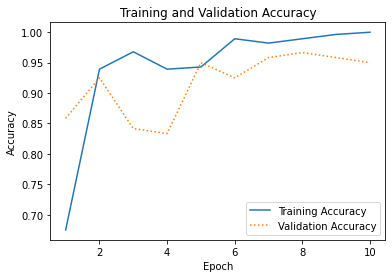

In [18]:
# 获取训练集和验证集的准确率
acc = hist.history['accuracy']  # 从训练历史中获取训练集的准确率
val_acc = hist.history['val_accuracy']  # 从训练历史中获取验证集的准确率

# 定义训练轮数范围
epochs = range(1, len(acc) + 1)  # 创建一个从1到训练轮数长度的范围，用于在图中作为x轴

# 绘制训练集的准确率曲线
plt.plot(epochs, acc, '-', label='Training Accuracy')  # 用实线绘制训练集的准确率，设置标签为“Training Accuracy”

# 绘制验证集的准确率曲线
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')  # 用虚线绘制验证集的准确率，设置标签为“Validation Accuracy”

# 设置图表的标题和坐标轴标签
plt.title('Training and Validation Accuracy')  # 设置图表标题为“Training and Validation Accuracy”
plt.xlabel('Epoch')  # 设置x轴的标签为“Epoch”
plt.ylabel('Accuracy')  # 设置y轴的标签为“Accuracy”

# 显示图例
plt.legend(loc='lower right')  # 在图表的右下角显示图例

# 绘制图表
plt.plot()  # 显示绘制的准确率曲线图

将测试图像通过网络运行，并使用混淆矩阵来评估结果。

Text(89.18, 0.5, 'Actual label')

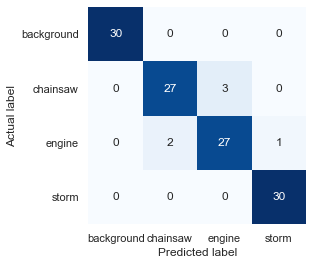

In [19]:
from sklearn.metrics import confusion_matrix  # 从 scikit-learn 库中导入混淆矩阵函数，用于评估分类模型的性能
import seaborn as sns  # 导入 seaborn 库，用于数据可视化
sns.set()  # 设置 seaborn 的默认样式，增强可视化效果

# 使用训练好的模型对测试集特征进行预测，得到预测标签
# y_predicted 是预测的结果，与实际标签 y_test_encoded 进行比较
y_predicted = model.predict(test_features)

# 计算混淆矩阵
# y_test_encoded.argmax(axis=1)：获取测试集标签的实际分类索引
# y_predicted.argmax(axis=1)：获取预测结果的分类索引
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))

# 定义分类标签，表示混淆矩阵中每个类别的含义
class_labels = ['background', 'chainsaw', 'engine', 'storm']

# 使用 seaborn 绘制混淆矩阵的热力图
sns.heatmap(
    mat,  # 要绘制的矩阵数据
    square=True,  # 矩阵单元格保持为正方形
    annot=True,  # 在图中显示每个单元格的数值
    fmt='d',  # 显示整数格式
    cbar=False,  # 不显示右侧的颜色条
    cmap='Blues',  # 使用蓝色系的颜色映射来增强可视化效果
    xticklabels=class_labels,  # x轴的分类标签
    yticklabels=class_labels  # y轴的分类标签
)

# 设置 x 轴的标签，表示预测标签
plt.xlabel('Predicted label')
# 设置 y 轴的标签，表示实际标签
plt.ylabel('Actual label')

该网络在识别不包含电锯或引擎声音的片段时表现得相当熟练。
虽然，它有时会混淆电锯声和引擎声，但这没有关系，因为两者的存在都可能表明雨林中有非法活动。

## Test with unrelated WAV files

“Sounds” 目录中有一个名为 “samples” 的子目录，其中包含CNN既未训练也未测试过的WAV文件。
这些WAV文件与用于训练和测试的样本无关；它们是从一个记录巴西遏制非法砍伐努力的YouTube视频中提取的。
现在可以使用之前训练的模型来分析这些文件是否包含伐木活动的声音。

首先，从第一个样本WAV文件创建一个声谱图，该文件包含在亚马逊森林中伐木工人砍树的音频。

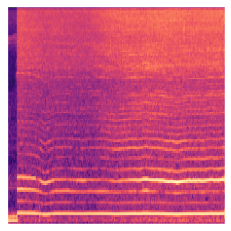

In [20]:
# 导入必要的库
from keras.preprocessing import image
import matplotlib.pyplot as plt

def create_spectrogram(input_file, output_file):
    # 此函数为你提供的函数，假设它能够生成声谱图
    # input_file: 输入的音频文件路径
    # output_file: 输出的声谱图文件路径
    pass  # 这里代表省略的实现，你需要自行定义函数体

# 调用函数生成声谱图
# 'Sounds/samples/sample1.wav' 是输入音频文件的路径
# 'Spectrograms/sample1.png' 是输出声谱图的保存路径
create_spectrogram('Sounds/samples/sample1.wav', 'Spectrograms/sample1.png')

# 加载生成的声谱图图像
# 'Spectrograms/sample1.png' 是之前生成的声谱图路径
# target_size=(224, 224) 将图像调整为 (224, 224) 大小，以便后续处理
x = image.load_img('Spectrograms/sample1.png', target_size=(224, 224))

# 创建图像展示窗口
plt.xticks([])  # 移除 x 轴刻度，防止显示干扰信息
plt.yticks([])  # 移除 y 轴刻度，防止显示干扰信息
plt.imshow(x)   # 显示加载的图像
plt.show()      # 展示图像窗口

预处理声谱图图像，将其传递给 MobileNetV2 进行特征提取，并对这些特征进行分类。

In [21]:
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

# 将图片对象转换为数组，方便后续的处理
# x 是通过 image 模块中的 img_to_array() 函数转换的图片数据
x = image.img_to_array(x)

# 为数组增加一个维度，因为模型的输入通常是 4 维张量
# 这里将输入图片从 (height, width, channels) 变成 (1, height, width, channels)
# axis=0 表示在第 0 维上扩展，这样可以满足模型输入的格式要求
x = np.expand_dims(x, axis=0)

# 对图片数据进行预处理，包括归一化等操作，确保输入符合模型的需求
# preprocess_input 是根据特定模型的要求对输入进行处理，以确保模型能够正常预测
x = preprocess_input(x)

# 使用预训练的基础模型 (base_model) 对输入数据进行特征提取
# y 是特征提取后的数据，它代表了输入图像的特征向量，用于进一步的分类预测
y = base_model.predict(x)

# 使用最终的模型对特征向量进行预测，得到分类结果
# predictions 包含每个类别的预测概率
predictions = model.predict(y)

# 遍历每个类别并输出预测结果
# 这里 i 代表类别的索引，label 是类别名称
# predictions[0][i] 表示预测结果中第 i 个类别的概率
for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

background: 0.0
chainsaw: 1.0
engine: 5.189781730147105e-35
storm: 0.0


从包含伐木卡车在雨林中轰鸣声音的WAV文件中创建一个声谱图。

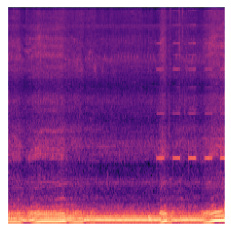

In [22]:
# 导入所需模块
import matplotlib.pyplot as plt  # 用于绘制图像
from keras.preprocessing import image  # 用于加载图像

# 创建频谱图函数，用于将音频文件转换为频谱图
# 'create_spectrogram' 是假设的函数名称，应该在代码中定义。假设其作用是从音频文件生成频谱图
create_spectrogram('Sounds/samples/sample2.wav', 'Spectrograms/sample2.png')  # 从音频文件 'sample2.wav' 生成频谱图，并保存为 'sample2.png'

# 加载频谱图
x = image.load_img('Spectrograms/sample2.png', target_size=(224, 224))  # 从路径中加载频谱图图像，并将图像大小调整为 224x224 像素

# 绘制频谱图
plt.xticks([])  # 隐藏 x 轴刻度
plt.yticks([])  # 隐藏 y 轴刻度
plt.imshow(x)  # 显示加载的频谱图图像
plt.show()  # 显示绘图窗口

预处理声谱图图像，将其传递给 MobileNetV2 进行特征提取，并对特征进行分类。

In [23]:
# 将输入的图片对象转换为NumPy数组
x = image.img_to_array(x)

# 在数组的第0维度上增加一个维度，将其扩展为四维张量，以适应模型的输入格式
# 原因：大多数深度学习模型需要批量输入，而此操作将单张图片扩展为“批量”的形式
x = np.expand_dims(x, axis=0)

# 对输入图片进行预处理，使其符合模型的输入要求（例如归一化、中心化等）
# 预处理可以提高模型的准确性和有效性
x = preprocess_input(x)

# 使用预训练的基础模型对输入图片进行特征提取
# base_model 是一个预训练模型，这一步会输出特征向量
y = base_model.predict(x)

# 使用自定义的模型对基础模型提取的特征进行分类预测
# model 通常是一个自定义分类模型，用于对特征进行分类
predictions = model.predict(y)

# 遍历类别标签，并输出每个类别对应的预测概率
for i, label in enumerate(class_labels):
    # 输出格式为：'类别名称: 预测概率'
    print(f'{label}: {predictions[0][i]}')


background: 0.0
chainsaw: 1.2086960212255175e-20
engine: 1.0
storm: 0.0


如果网络对任一样本的分类错误，尝试使用 MobileNetV2 的输出重新训练它。

需要注意的是，神经网络每次训练的方式都会有所不同，部分原因是Keras使用小的随机值来初始化权重和偏差。

在实际的应用中，通常会对神经网络进行20次或更多次的训练，并取平均结果来量化其准确率